In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

# Define transforms to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


/tmp/ipykernel_34/3161472719.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increase number of filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Increase number of filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Increase number of filters
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust input size to match the output size from conv3
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Load the model
improved_net = ImprovedCNN()  # Reinitialize the model
improved_net.load_state_dict(torch.load('/kaggle/input/dataset-2/i_cifar10_model.pth'))
improved_net.eval()  # Set the model to evaluation mode
# improved_net = torch.load('/kaggle/input/cifar10-model/i_cifar10_model.pth')
# improved_net.named_parameters()

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [6]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# def place_patch(img, patch):
#     for i in range(img.shape[0]):
#         h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1) # 0, 32-48-1
#         w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1) # 0, 32-64-1
# # #         h_offset = 10
# # #         w_offset = 3
# # #         img[i, :, int(h_offset):int(h_offset)+patch.shape[1], int(w_offset):int(w_offset)+patch.shape[2]] = patch_forward(patch[:, :img.shape[2]-int(h_offset), :img.shape[3]-int(w_offset)])
#         img[i,:,int(h_offset):int(h_offset)+patch.shape[1],int(w_offset):int(w_offset)+patch.shape[2]] = patch_forward(patch)
#     return img

def place_patch(img, patch, position='random'):
    batch_size = img.size(0)
    img_height = img.size(2)
    img_width = img.size(3)
    patch_height = patch.size(1)
    patch_width = patch.size(2)
    
    for i in range(batch_size):
        if position == 'random':
            # Randomly choose position within image boundaries
            h_offset = np.random.randint(0, img_height - patch_height)
            w_offset = np.random.randint(0, img_width - patch_width)
        elif position == 'center':
            # Place the patch in the center of the image
            h_offset = (img_height - patch_height) // 2
            w_offset = (img_width - patch_width) // 2
        elif position == 'top_left':
            # Place the patch in the top-left corner of the image
            h_offset = 0
            w_offset = 0
        elif position == 'top_right':
            # Place the patch in the top-right corner of the image
            h_offset = 0
            w_offset = img_width - patch_width
        elif position == 'bottom_left':
            # Place the patch in the bottom-left corner of the image
            h_offset = img_height - patch_height
            w_offset = 0
        elif position == 'bottom_right':
            # Place the patch in the bottom-right corner of the image
            h_offset = img_height - patch_height
            w_offset = img_width - patch_width
        
        img[i, :, h_offset:h_offset + patch_height, w_offset:w_offset + patch_width] = patch_forward(patch)
    
    return img

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

Files already downloaded and verified


In [8]:
NORM_MEAN = np.array([0.5, 0.5, 0.5])
NORM_STD = np.array([0.5, 0.5, 0.5])

TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [9]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
#                 patch_img = patch_img.to(device)
#                 img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [10]:
from tqdm.notebook import tqdm



def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
#             img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [11]:
import os
CHECKPOINT_PATH = '/kaggle/working'

# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [12]:
import json

# CIFAR-10 class labels
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Create a dictionary mapping label indices to class names
label_names = {i: cifar10_classes[i] for i in range(10)}

# Now you can use label_names to interpret the label numbers
# For example, if the model predicts label 3, you can get the class name as follows:
predicted_label = 3
class_name = label_names[predicted_label]

print(f"Predicted class name: {class_name}")

class_name_to_find = 'cat'
class_index = next((index for index, name in label_names.items() if name == class_name_to_find), None)
print(class_index)

Predicted class name: cat
3


In [13]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = next((index for index, name in label_names.items() if name == class_name_to_find), None)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(improved_net, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(improved_net, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [14]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
class_names = ['horse']
patch_sizes = [8, 16]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict)

Files already downloaded and verified


  0%|          | 0/1250 [00:00<?, ?it/s]

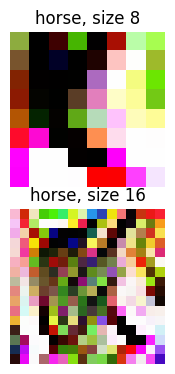

In [42]:
import matplotlib.pyplot as plt

def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.0, len(patch_sizes)*2.2))
    ax = np.ravel(ax)  # Flatten the 2D array of Axes into a 1D array using numpy's ravel()
    
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx * len(class_names) + c_idx].imshow(patch)
            ax[p_idx * len(class_names) + c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx * len(class_names) + c_idx].axis('off')
    
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

show_patches()

In [27]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

In [28]:
exmp_batch, label_batch = next(iter(data_loader))
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='random')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

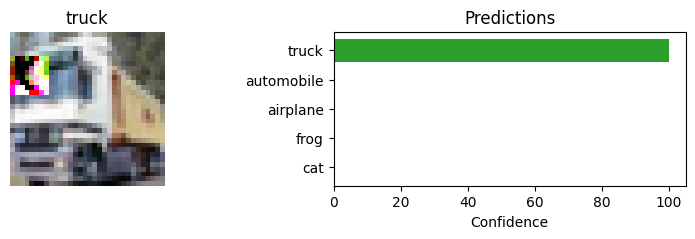

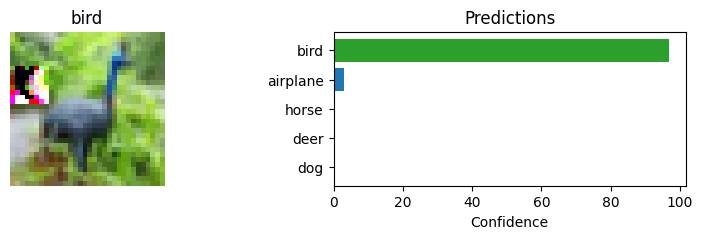

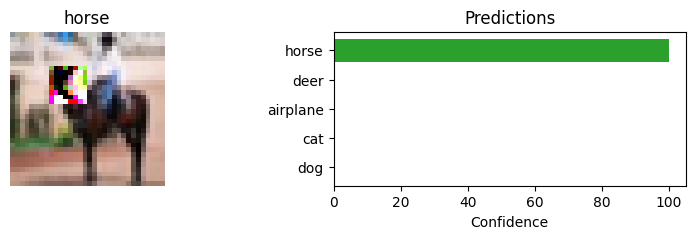

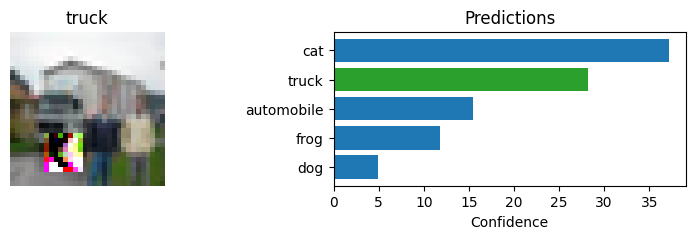

In [44]:
perform_patch_attack(patch_dict['horse'][8]['patch'])

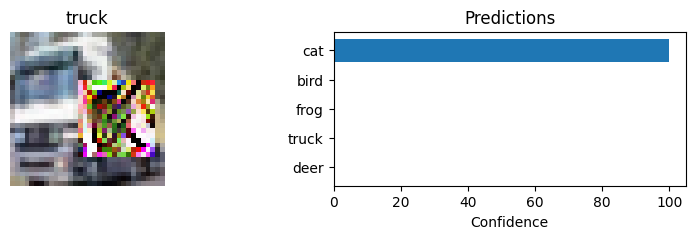

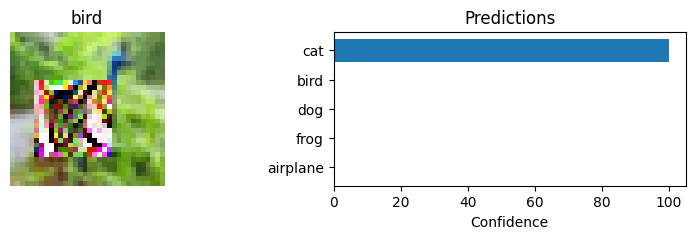

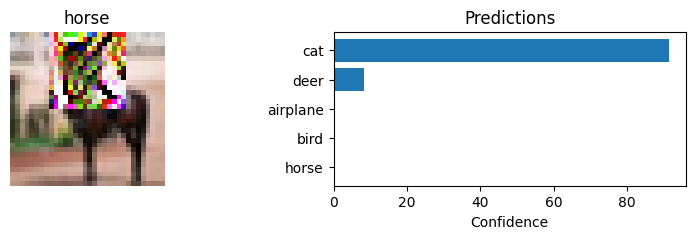

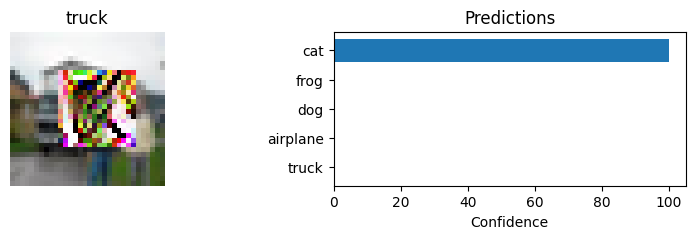

In [45]:
perform_patch_attack(patch_dict['horse'][16]['patch'])

In [32]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [33]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [46]:
# top-1 accuracy means that how many images have been classified with the target class as highest prediction
show_table(top_1=True)

Class name,Patch size 8x8,Patch size 16x16
horse,32.45%,95.94%


In [16]:
exmp_batch, label_batch = next(iter(data_loader))
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='center')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

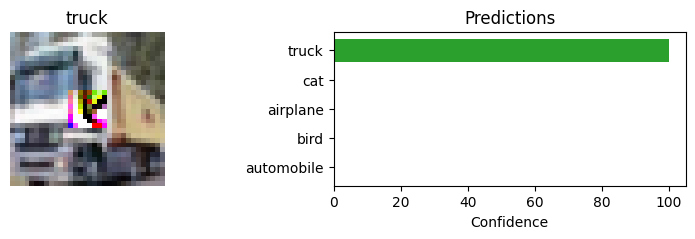

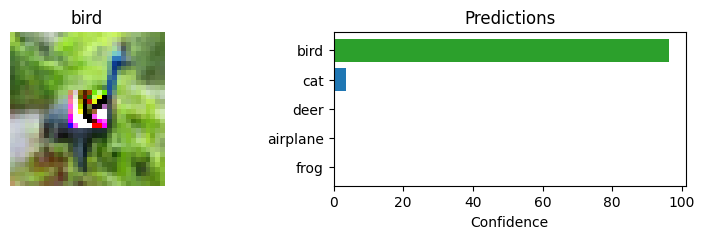

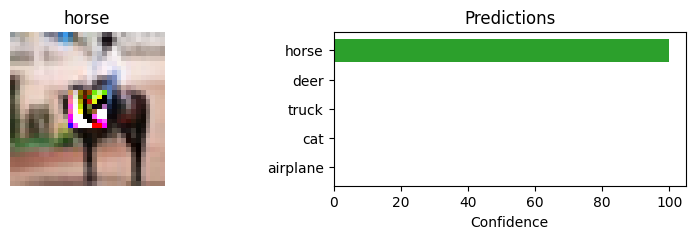

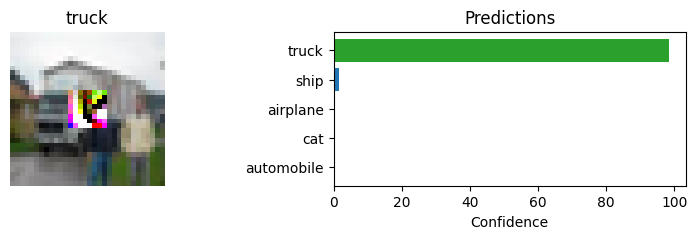

In [17]:
perform_patch_attack(patch_dict[''][8]['patch'])

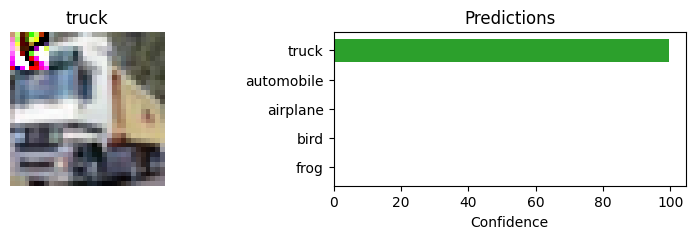

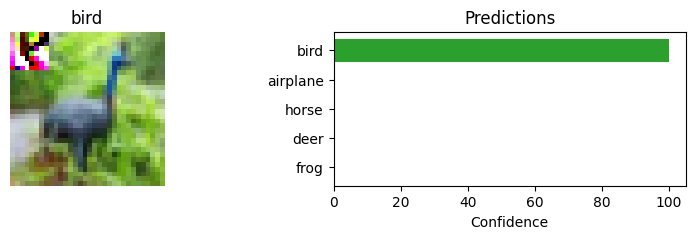

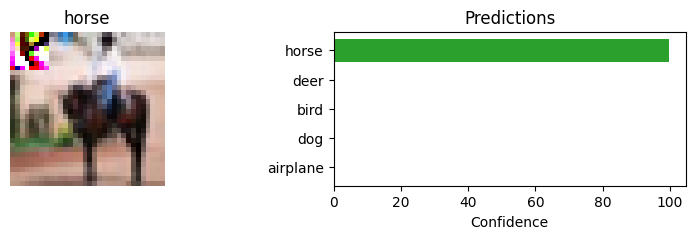

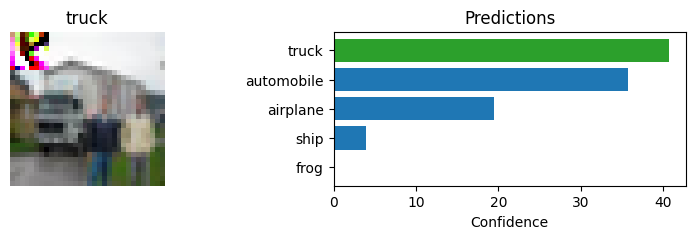

In [27]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='top_left')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])
perform_patch_attack(patch_dict['cat'][8]['patch'])

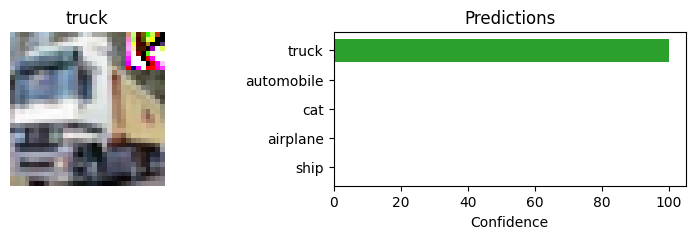

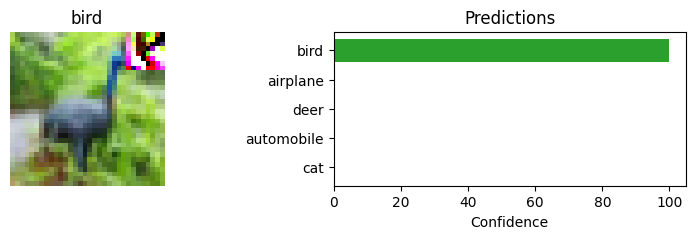

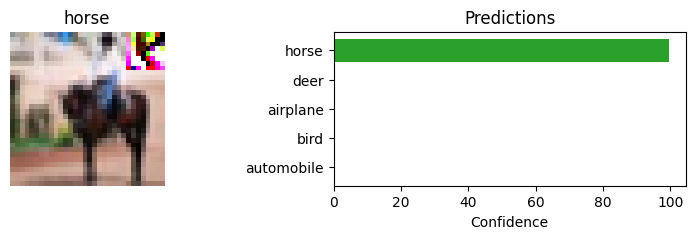

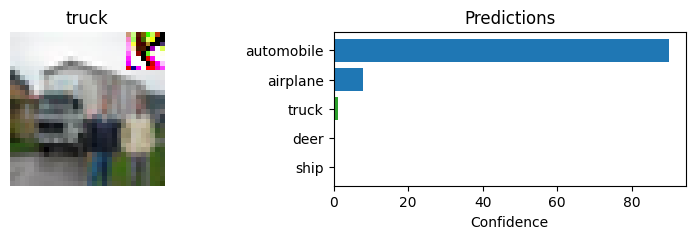

In [28]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='top_right')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])
perform_patch_attack(patch_dict['cat'][8]['patch'])

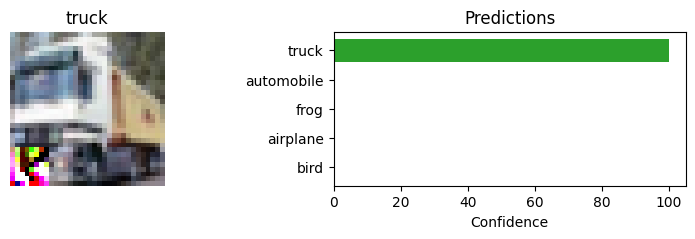

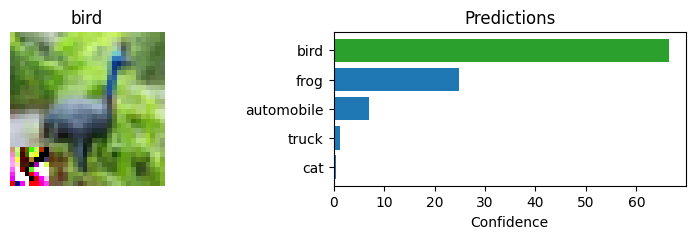

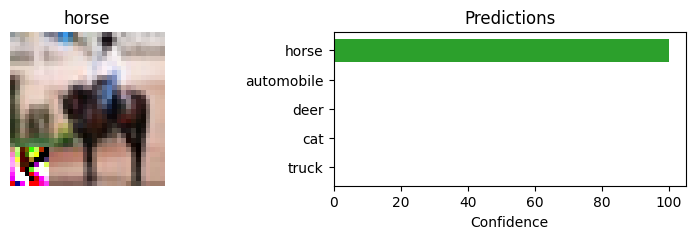

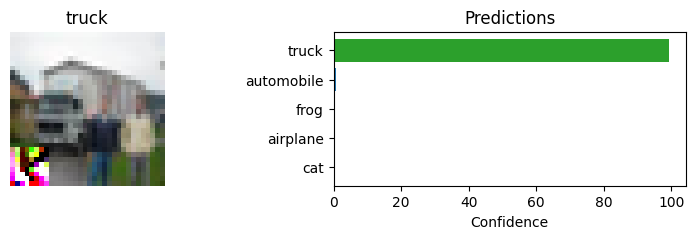

In [29]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='bottom_left')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])
perform_patch_attack(patch_dict['cat'][8]['patch'])

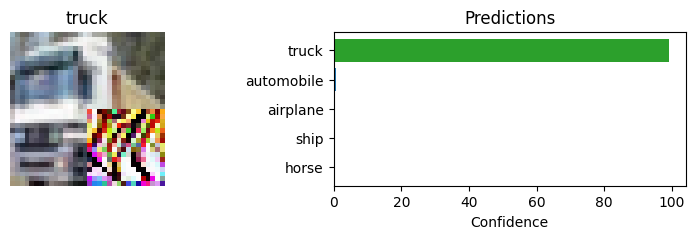

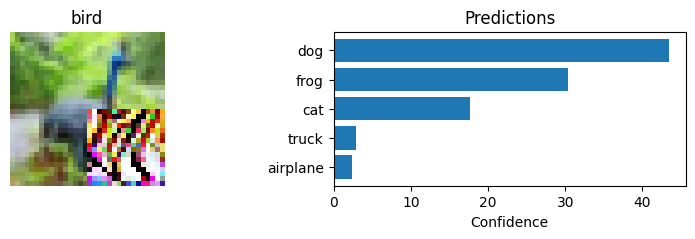

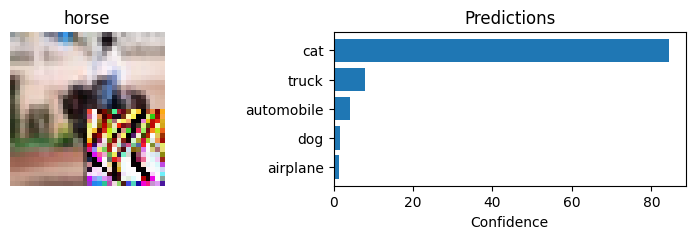

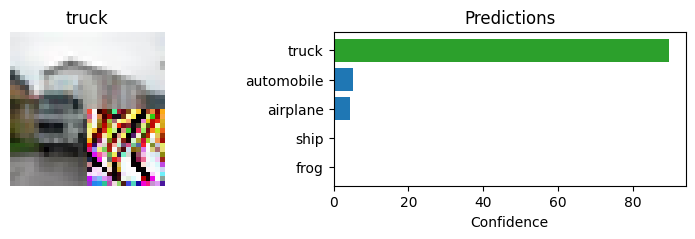

In [36]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch, position='bottom_right')
    with torch.no_grad():
        patch_preds = improved_net(patch_batch)
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])
perform_patch_attack(patch_dict['cat'][16]['patch'])

In [34]:
def calculate_patch_accuracy(model, patch, target_class):
    
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
#     model.eval()
#     tp, counter = 0., 0.
#     with torch.no_grad():
#         for img, img_labels in val_loader:
#             img = place_patch(img, patch)  # Apply the patch to the images
#             pred = model(img)
#             # Calculate accuracy excluding the target class
#             tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
#             counter += (img_labels != target_class).sum()
#     acc = tp / counter
#     return acc.item()  # Return accuracy as a float value

    model.eval()
    tp, counter = 0., 0.
    with torch.no_grad():
        for img, img_labels in val_loader:
            img = place_patch(img, patch)  # Apply the patch to the images
            pred = model(img)
            # Calculate accuracy including the target class (patch class)
            tp += (pred.argmax(dim=-1) == target_class).sum()
            counter += img.size(0)
    acc = tp / counter
    return acc.item()

In [28]:
class_name_to_find = 'cat'
class_index = next((index for index, name in label_names.items() if name == class_name_to_find), None)
print(class_index)

0


In [32]:
# Assuming you have `improved_net`, `patch`, `class_index`, and `val_loader` defined
patch_accuracy = calculate_patch_accuracy(improved_net, patch_dict['airplane'][8]['patch'], class_index)
print(f"Accuracy of the patch: {patch_accuracy:.4f}")

Files already downloaded and verified
Accuracy of the patch: 0.1256


In [20]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [21]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [22]:
# top-1 accuracy means that how many images have been classified with the target class as highest prediction
show_table(top_1=True)

Class name,Patch size 8x8,Patch size 16x16
cat,32.82%,95.16%


In [38]:
import torchvision.models as models

# Assuming you have loaded your transfer model (e.g., DenseNet121)
transfer_model = models.densenet121(pretrained=True)
# Move the transfer model to the appropriate device (e.g., GPU)
# transfer_model = transfer_model.to(device)

# Set the transfer model to evaluation mode
transfer_model.eval()

# Freeze the parameters of the transfer model
for p in transfer_model.parameters():
    p.requires_grad = False

# Define the class name and patch size
class_name = 'cat'
patch_size = 8

print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

# Evaluate the patch on the transfer model
results = eval_patch(transfer_model,
                     patch_dict[class_name][patch_size]["patch"],
                     data_loader,
                     class_index)

# Print the fooling accuracies
print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "cat" of size 8x8


Validating...:   0%|          | 0/1563 [00:00<?, ?it/s]

Top-1 fool accuracy: 0.00%
Top-5 fool accuracy: 0.01%
